In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sys import path
path.append("../utils/")

from utils import get_datasets

In [16]:
DATASETS = ["webkb", "20ng", "acm", "reut"]
DATA_SOURCE = "/home/welton/data/stacking/stacking_output"

In [17]:
def load_stacking_preds(dset, strategy):
    preds = []
    for fold in np.arange(10):
        y_pred = np.load(f"{DATA_SOURCE}/{dset}/10_folds/logistic_regression/{strategy}/fold_{fold}/y_pred.npy")
        preds.append(y_pred)
    preds = np.hstack(preds)
    return preds

In [18]:
pd_datasets = get_datasets(DATASETS, path="/home/welton/data/pd_datasets/__dset__.csv", sep=';')

In [19]:
~(np.array([True, False, True]))

array([False,  True, False])

In [26]:
def plot_bar(diff):

    counts = pd.Series(diff).value_counts(normalize=True)
    keys = list(counts.keys())
    keys.sort()
    y = [ counts[k] * 100 for k in keys ]
    plt.bar(keys, y)
    _ = plt.xticks(ticks=keys, labels=keys)

def plot_cdf(diff):

    counts = pd.Series(diff).value_counts(normalize=True)
    keys = list(counts.keys())
    keys.sort()
    total = np.sum(counts.values)
    acc = 0
    cdf = []
    for k in keys:
        acc += counts[k] / total
        cdf.append(acc)
    plt.bar(keys, cdf)
    _ = plt.xticks(ticks=keys, labels=keys)


In [27]:
pd_datasets["webkb"].columns

Index(['spr', 'kpr', 'xtr', 'xfr', 'stmk', 'ltmk', 'lpr', 'str', 'ltr', 'lfr',
       'kfr', 'xlnet', 'ktmk', 'rep_bert', 'ktr', 'bert', 'sfr', 'xtmk',
       'xlnet_softmax', 'xpr', 'label', 'fold_id', 'docs', 'conc_size',
       'hit_counts', 'conc_pred'],
      dtype='object')

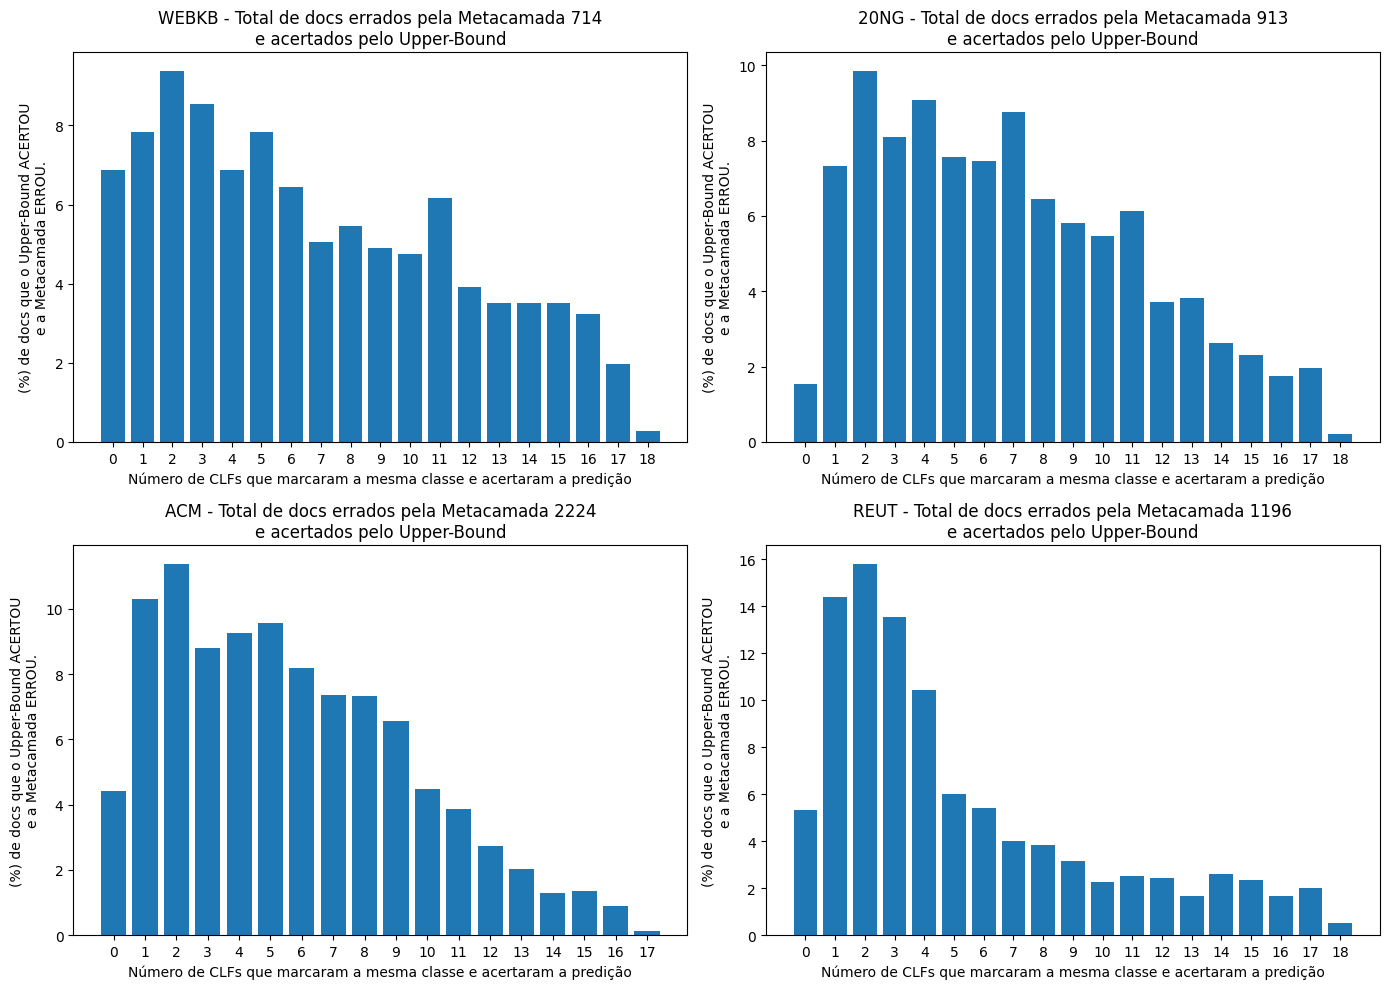

In [36]:
plt.figure(figsize=(14, 10))
for pidx, dset in enumerate(DATASETS):
    meta_layer = load_stacking_preds(dset, "proba")
    upper_bound = load_stacking_preds(dset, "upper_bound")
    df = pd_datasets[dset]
    # Docs where meta_layer missed.
    a1 = ~(meta_layer == df.label.values)
    # Docs where upper bound hit.
    a2 = upper_bound == df.label.values
    preds = df.drop(columns=["xlnet", "bert", "label", "fold_id", "conc_size", "conc_pred", "hit_counts"])
    hits = np.sum(preds.values == df.label.values[:, None], axis=1)
    diff = hits[a1 == a2]
    plt.subplot(2, 2, pidx + 1)
    plot_bar(diff)
    plt.title(f"{dset.upper()} - Total de docs errados pela Metacamada {diff.shape[0]}\ne acertados pelo Upper-Bound")
    plt.xlabel("Número de CLFs que marcaram a mesma classe e acertaram a predição")
    plt.ylabel(f"(%) de docs que o Upper-Bound ACERTOU\ne a Metacamada ERROU.")
plt.tight_layout(h_pad=1.2)

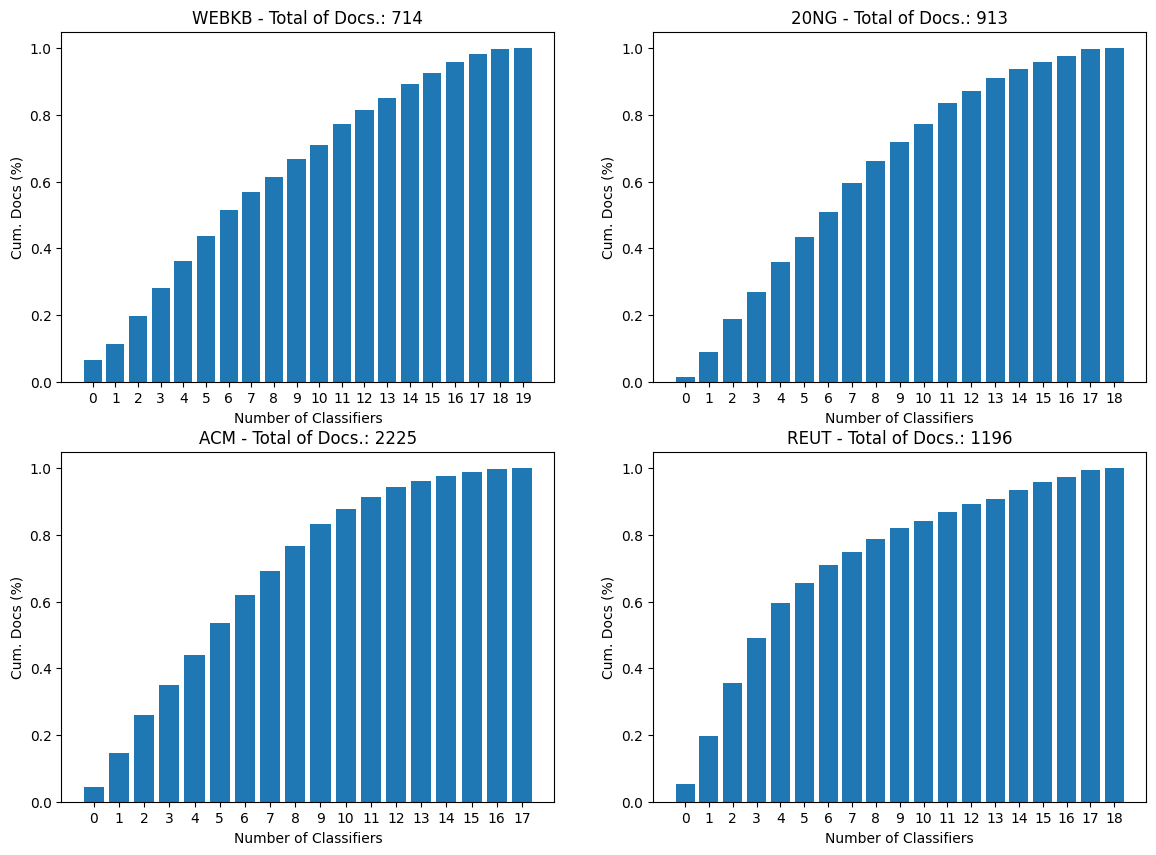

In [ ]:
plt.figure(figsize=(14, 10))
for pidx, dset in enumerate(DATASETS):
    meta_layer = load_stacking_preds(dset, "proba")
    oracle_upper = load_stacking_preds(dset, "oracle_upper")
    a1 = ~(meta_layer == pd_datasets[dset].label.values)
    a2 = oracle_upper == pd_datasets[dset].label.values
    df = pd_datasets[dset]
    preds = df.drop(columns=["bert", "label", "fold_id"])
    hits = np.sum(preds.values == df.label.values[:, None], axis=1)
    diff = hits[a1 == a2]
    plt.subplot(2, 2, pidx + 1)
    plot_cdf(diff)
    plt.title(f"{dset.upper()} - Total of Docs.: {diff.shape[0]}")
    plt.xlabel("Number of Classifiers")
    plt.ylabel("Cum. Docs (%)")